In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import io

### Prep dataset

In [2]:
#get handwritten text dataset from hugging face
splits = {'train': 'data/train.parquet', 'validation': 'data/validation.parquet', 'test': 'data/test.parquet'}
df_train = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["test"])

df_train.shape, df_val.shape, df_test.shape

/home/jacob/Desktop/programming/learning/ml/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


((6482, 2), (976, 2), (2915, 2))

In [3]:
charset = sorted(list(set(''.join(df_train['text'].tolist() + df_val['text'].tolist() + df_test['text'].tolist()))))

print('# of unique characters: ', len(charset))

idx_to_char = dict(list(enumerate(charset, start=1))) #start at 1 to allow pytorch's CTC loss to insert breaks
char_to_idx = dict([(idx_to_char[k], k) for k in idx_to_char.keys()])

def encode(text) -> np.array:
    #insert break characters
    return np.array([char_to_idx[ch] for ch in text])

def decode(arr) -> str:
    return ''.join([idx_to_char[ch] for ch in arr])

# of unique characters:  79


In [4]:
def sample(df, n):
    samp_df = df.sample(n)
    img_arrays = samp_df['image'].apply(lambda x: x['bytes']).apply(lambda x: np.array(Image.open(io.BytesIO(x)))).tolist()
    img_texts = samp_df['text'].tolist()
    img_texts_encoded = samp_df['text'].apply(encode).apply(torch.tensor).tolist()
    return list(zip(img_arrays, img_texts, img_texts_encoded))

Board . The board is laying a cable along a seven-


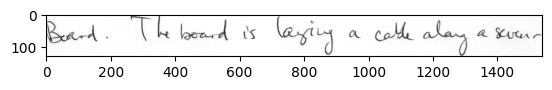

In [5]:
batch = sample(df_train, 10)
print(batch[0][1])
plt.imshow(batch[0][0], cmap='gray')

### Using simple RNN + CTC

In [6]:
#init params

INPUT_SIZE = 128
OUTPUT_PROB_SIZE = len(charset) + 1 #79 + blank char for ctc loss
HIDDEN_SIZE = 100

#weights applied to x input, [128 x 1]/[1 x 128] @ [128 x 20]--> [1 x 20]
Wx = torch.randn((INPUT_SIZE, HIDDEN_SIZE)) / INPUT_SIZE**0.5

#weights applied to prev hidden layer, [1 x 20] @ [20 x 20] --> [1 x 20]
Wh = torch.randn((HIDDEN_SIZE, HIDDEN_SIZE)) / HIDDEN_SIZE**0.5
bh = torch.randn(HIDDEN_SIZE) #bias 20 dim

#weights to generate output probabilities from combined inputs [1 x 20] @ [20 x output size] --> [1 x output size]
Wp = torch.randn((HIDDEN_SIZE, OUTPUT_PROB_SIZE)) / HIDDEN_SIZE**0.5

params = [Wx, Wh, bh, Wp]
for param in params:
    param.requires_grad=True

In [7]:
#feed forward
out_prob_batch = []
targets_batch = []
for img in batch:
    #normalize input and cast to torch tensor
    x = (torch.tensor(img[0]) - img[0].mean()) / img[0].var()
    out_prob = []
    for i in range(x.shape[1]):
        if i == 0:
            h_t = x[:, i] @ Wx + bh
        else:
            h_t = x[:, i] @ Wx + h_t @ Wh + bh
        h_t = torch.sigmoid(h_t)
        logits = h_t @ Wp
        logprobs = F.log_softmax(logits, dim=0)
        out_prob.append(logprobs)
    logp = torch.stack(out_prob)
    out_prob_batch.append(logp)
    targets_batch.append(img[2])

#prepare inputs to pytorch ctc loss
log_probs = torch.nn.utils.rnn.pad_sequence(out_prob_batch)
targets = torch.nn.utils.rnn.pad_sequence(targets_batch).reshape(len(targets_batch), -1)
input_lengths = torch.tensor([p.shape[0] for p in out_prob_batch])
target_lengths = torch.tensor([t.shape[0] for t in targets_batch])

In [8]:
for p in out_prob_batch:
    print(p.shape)

torch.Size([1539, 80])
torch.Size([2054, 80])
torch.Size([1992, 80])
torch.Size([1630, 80])
torch.Size([1544, 80])
torch.Size([1624, 80])
torch.Size([1285, 80])
torch.Size([2780, 80])
torch.Size([2665, 80])
torch.Size([2615, 80])


In [9]:
#use pytorch to get the CTC loss
ctc_loss = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
loss = ctc_loss(log_probs=log_probs, targets=targets, input_lengths=input_lengths, target_lengths=target_lengths)

print('loss: ', loss.item())

loss.backward()
lr = 0.01
for param in params:
    param = -lr * param.grad

loss:  158.50473022460938


In [86]:
#set up full model/training loop with pytorch classes

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=False)
        self.linear = torch.nn.Linear(in_features=hidden_size, out_features=output_size, bias=False)

    def forward(self, batch):
        out_probs = []
        for img in batch:
            #normalize input
            x = (img - img.mean()) / img.var()
            out_prob = []
            h0 = torch.zeros(1, self.hidden_size)
            out, _ = self.rnn(x, h0)
            out = self.linear(out)
            out = F.log_softmax(out, dim=1)
            out_probs.append(out)

        #combine out_probs into single log prob vector
        log_probs = torch.nn.utils.rnn.pad_sequence(out_probs)

        return log_probs

    def compute_loss(self, log_probs, batch_targets):
        #prepare inputs to pytorch ctc loss
        pad_log_probs = torch.nn.utils.rnn.pad_sequence(log_probs)
        pad_targets = torch.nn.utils.rnn.pad_sequence(batch_targets).T
        input_lengths = torch.tensor([p.shape[0] for p in log_probs])
        target_lengths = torch.tensor([t.shape[0] for t in batch_targets])

        #compute CTC loss
        ctc_loss = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
        loss = ctc_loss(log_probs=pad_log_probs, targets=pad_targets, input_lengths=input_lengths, target_lengths=target_lengths)

        return loss

In [88]:
#define hyperparams and construct model object
learning_rate = 0.1
num_epochs = 10

rnn = RNN(input_size=128, hidden_size=250, output_size=80)
optim = optim.Adam(rnn.parameters(), lr=learning_rate)

In [83]:
#sample data
batch = sample(df_train, 10)
batch_imgs = [torch.tensor(b[0], dtype=torch.float32).T for b in batch]
batch_targets = [b[2] for b in batch]

In [99]:
torch.nn.utils.rnn.pad_sequence(batch_targets).T.shape

torch.Size([10, 58])

In [96]:
for b in batch_targets:
    print(b.shape)

torch.Size([45])
torch.Size([23])
torch.Size([50])
torch.Size([43])
torch.Size([16])
torch.Size([41])
torch.Size([37])
torch.Size([52])
torch.Size([33])
torch.Size([58])


In [85]:
#forward pass
logprobs = rnn.forward(batch_imgs)

In [89]:
#compute loss and gradients
loss = rnn.compute_loss(logprobs, batch_targets)
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

RuntimeError: target_lengths must be of size batch_size

In [ ]:
#compute loss with my custom CTC

#init ctc matrix
ctc = torch.zeros((logp.shape[0], s[0][2].shape[0]))
target = s[0][2]
ctc[0, 0] = logp[0, target[0]]
ctc[0, 1] = logp[0, target[1]]

#dynamic programming to compute conditional probabilities
for t in range(1, ctc.shape[0]):
    for o in range(0, ctc.shape[1]):
        if o == 0:
            ctc[t, o] = ctc[t-i, o] + logp[t, target[o]]
        elif o < 3 or target[o] == 0:
            ctc[t, o] = torch.logaddexp(torch.tensor(ctc[t-1, o-1]), torch.tensor(ctc[t-1, o])).item() + logp[t, target[o]]
        elif target[o] == target[o-2]:
            ctc[t, o] = torch.logaddexp(torch.tensor(ctc[t-1, o-1]), torch.tensor(ctc[t-1, o])).item() + logp[t, target[o]]
        else:
            ctc[t, o] = torch.logsumexp(torch.tensor([ctc[t-1, o-2], ctc[t-1, o-1], ctc[t-1,o]]), dim=0).item() + logp[t, target[o]]

#compute final loss
loss = -ctc[-1, -2:].sum() / target.shape[0]
loss